In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('DS_Sber.csv', sep=';')
data.columns = data.columns.str.lower()
data['reportdate'] = data['reportdate'].str.replace('.', '/')
data["reportdate"] = pd.to_datetime(data["reportdate"], infer_datetime_format=True)

data.head(10)

C:\Temp\ipykernel_9768\4256145899.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['reportdate'] = data['reportdate'].str.replace('.', '/')


,reportdate,value
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149
5,2014-01-04,3417092149
6,2014-01-05,3417092149
7,2014-01-06,3320846785
8,2014-01-07,3320846785
9,2014-01-08,3630283744


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   reportdate  2111 non-null   datetime64[ns]
 1   value       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


In [4]:
data.describe()

,value
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


<AxesSubplot: >

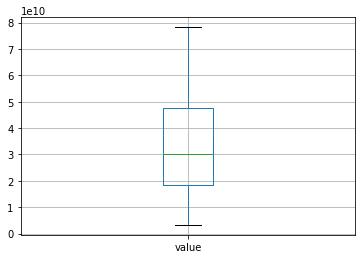

In [5]:
data.boxplot(['value'])

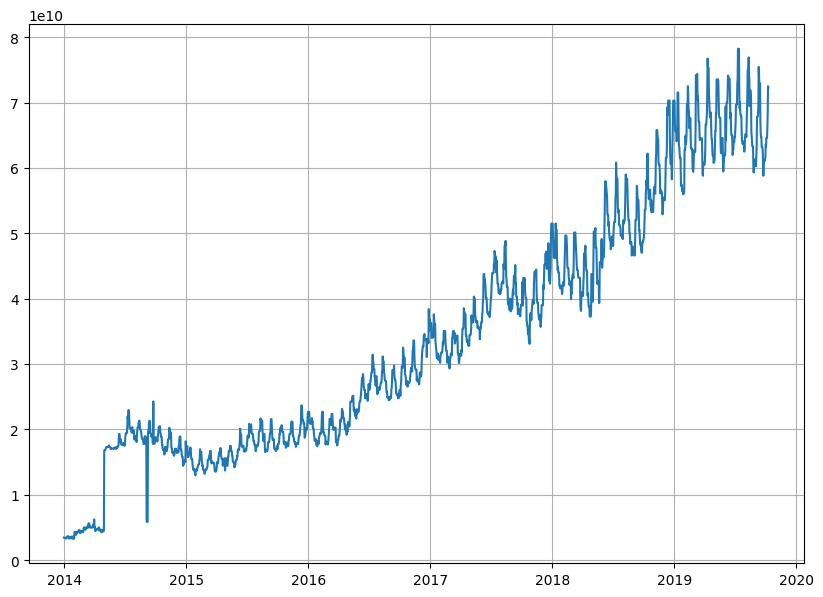

In [6]:
plt.figure(figsize=(10, 7))

plt.grid(True)
plt.plot(data.reportdate, data.value)

plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

In [8]:
df = data['value'].values.reshape((-1, 1))
df

array([[ 3457625638],
       [ 3417092149],
       [ 3417092149],
       ...,
       [68424049766],
       [72492897583],
       [72307860851]], dtype=int64)

In [9]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

dataset_train

array([[0.00303794],
       [0.00233355],
       [0.00233355],
       ...,
       [0.9404834 ],
       [0.9404834 ],
       [0.95731266]])

In [11]:
def create_dataset(df, window):
    x = []
    y = []
    for i in range(window, df.shape[0]):
        x.append(df[i-window:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return (x, y)

In [35]:
window = 60

x_train, y_train = create_dataset(dataset_train, window)
x_test, y_test = create_dataset(dataset_test, window)

x_train, y_train

(array([[0.00303794, 0.00233355, 0.00233355, ..., 0.01716429, 0.01825687,
         0.02668751],
        [0.00233355, 0.00233355, 0.00233355, ..., 0.01825687, 0.02668751,
         0.03002754],
        [0.00233355, 0.00233355, 0.00233355, ..., 0.02668751, 0.03002754,
         0.03002754],
        ...,
        [0.93021846, 0.91690485, 0.90887413, ..., 0.93544849, 0.96823825,
         0.9404834 ],
        [0.91690485, 0.90887413, 0.86130237, ..., 0.96823825, 0.9404834 ,
         0.9404834 ],
        [0.90887413, 0.86130237, 0.86130237, ..., 0.9404834 , 0.9404834 ,
         0.9404834 ]]),
 array([0.03002754, 0.03002754, 0.03002754, ..., 0.9404834 , 0.9404834 ,
        0.95731266]))

In [42]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train.shape, y_train.shape

((1628, 60, 1), (1628,))

In [37]:
def create_model():
    model = Sequential(name='Sber')
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dense(units=1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [38]:
model.summary()

Model: "Sber"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 360, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 360, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 360, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 360, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 149,057
Trainable params: 149,057
Non-trainable 

In [39]:
model = create_model()

model.fit(x_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
102/102 [==============================] - 7s 42ms/step - loss: 0.0110
Epoch 2/50
102/102 [==============================] - 4s 40ms/step - loss: 0.0030
Epoch 3/50
102/102 [==============================] - 4s 40ms/step - loss: 0.0030
Epoch 4/50
102/102 [==============================] - 4s 41ms/step - loss: 0.0024
Epoch 5/50
102/102 [==============================] - 5s 48ms/step - loss: 0.0019
Epoch 6/50
102/102 [==============================] - 5s 45ms/step - loss: 0.0016
Epoch 7/50
102/102 [==============================] - 4s 42ms/step - loss: 0.0014
Epoch 8/50
102/102 [==============================] - 6s 57ms/step - loss: 0.0014
Epoch 9/50
102/102 [==============================] - 4s 41ms/step - loss: 0.0015
Epoch 10/50
102/102 [==============================] - 4s 42ms/step - loss: 0.0013
Epoch 11/50
102/102 [==============================] - 4s 42ms/step - loss: 0.0015
Epoch 12/50
102/102 [==============================] - 4s 41ms/step - loss: 0.0013
Epoch 13/50
1

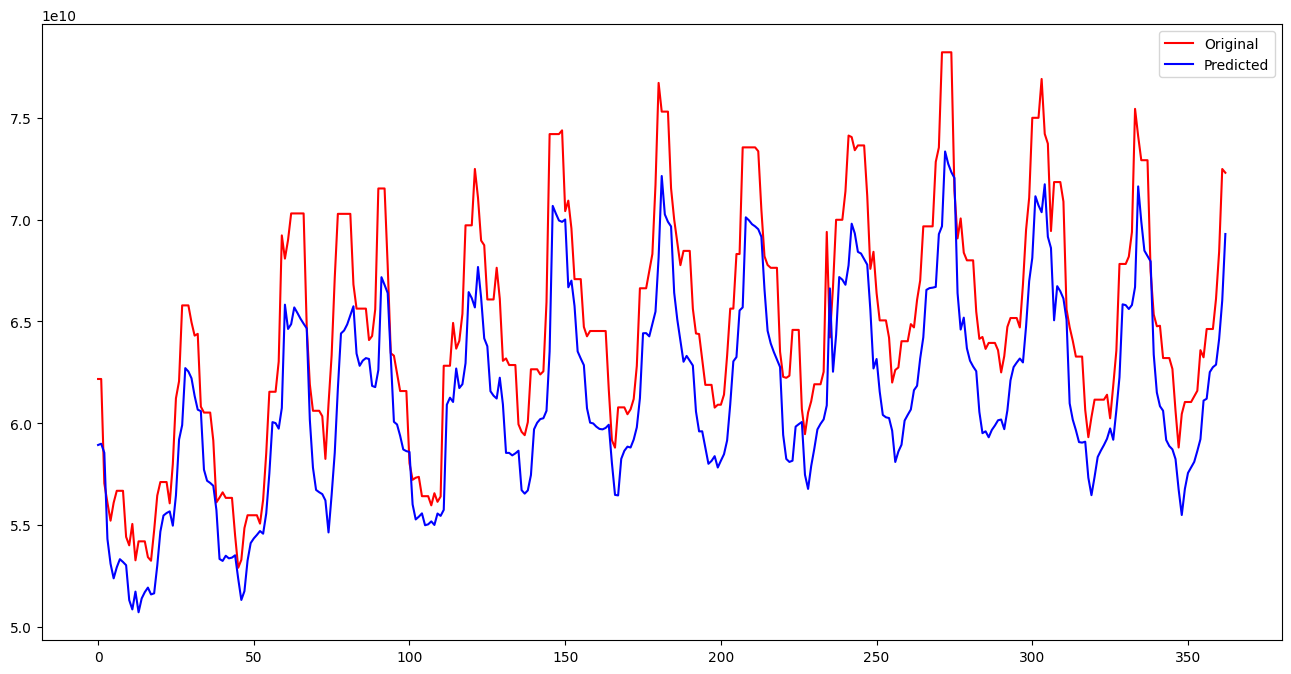

In [40]:
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(16, 8))

plt.plot(y_test_scaled, color='r', label='Original')
plt.plot(predict, color='b', label='Predicted')

plt.legend()

plt.show()

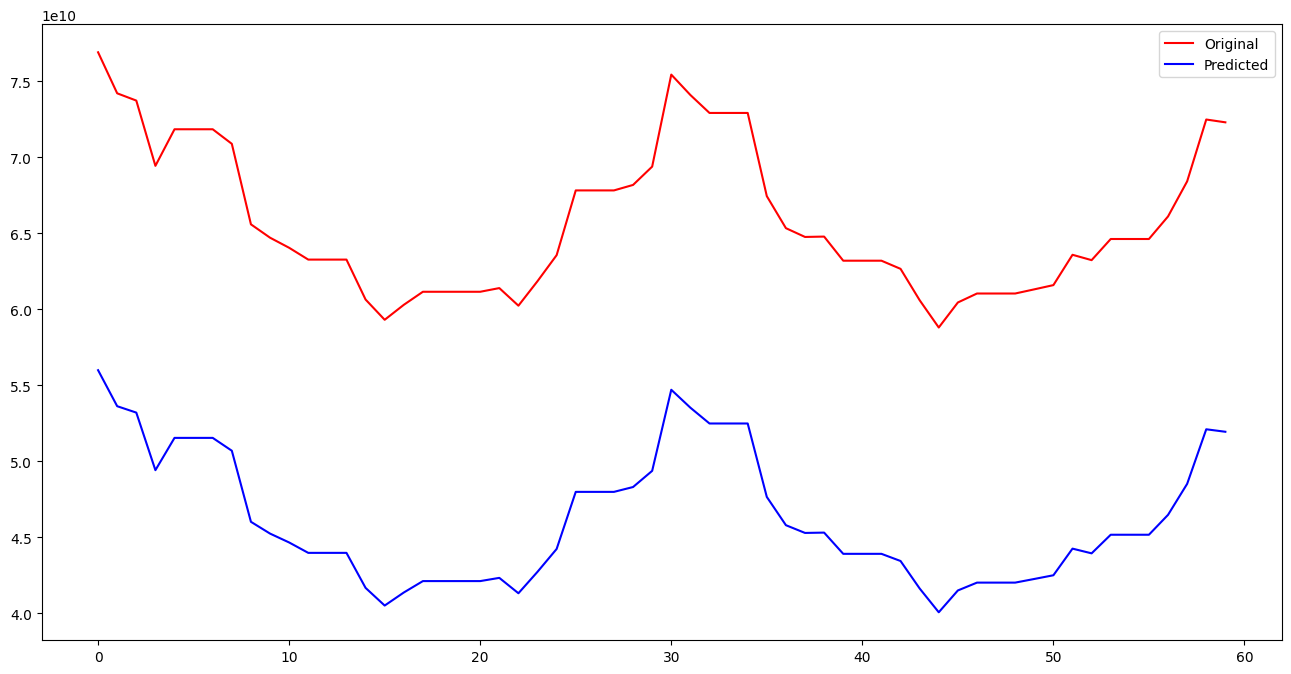

In [41]:
dataset_valid = np.array(df[-window:])

dataset_valid = scaler.transform(dataset_valid)

predict = model.predict(dataset_valid)
predict = scaler.inverse_transform(predict)
dataset_valid = scaler.inverse_transform(dataset_valid)

plt.figure(figsize=(16, 8))

plt.plot(dataset_valid, color='r', label='Original')
plt.plot(predict, color='b', label='Predicted')

plt.legend()

plt.show()